In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from helpers.helper_functions import *

# Handling text 2 exercise
[Handling text exercisses ADApted drom ADA 2018 final exam]

The Sheldon Cooper we all know and love (OK, some of us might not know him, and some might not love him) from the TV series "The Big Bang Theory" has gotten into an argument with Leonard from the same TV show. Sheldon insists that he knows the show better than anyone, and keeps making various claims about the show, which neither of them know how to prove or disprove. The two of them have reached out to you ladies and gentlemen, as data scientists, to help them. You will be given the full script of the series, with information on the episode, the scene, the person saying each dialogue line, and the dialogue lines themselves.

Leonard has challenged several of Sheldon's claims about the show, and throughout this exam you will see some of those and you will get to prove or disprove them, but remember: sometimes, we can neither prove a claim, nor disprove it!

## Task A: Picking up the shovel

**Note: You will use the data you preprocess in this task in all the subsequent ones.**

Our friends' argument concerns the entire show. We have given you a file in the `data/` folder that contains the script of every single episode. New episodes are indicated by '>>', new scenes by '>', and the rest of the lines are dialogue lines. Some lines are said by multiple people (for example, lines indicated by 'All' or 'Together'); **you must discard these lines**, for the sake of simplicity. However, you do not need to do it for Q1 in this task -- you'll take care of it when you solve Q2.

**Q1**. Your first task is to extract all lines of dialogue in each scene and episode, creating a dataframe where each row has the episode and scene where a dialogue line was said, the character who said it, and the line itself. You do not need to extract the proper name of the episode (e.g. episode 1 can appear as "Series 01 Episode 01 - Pilot Episode", and doesn't need to appear as "Pilot Episode"). Then, answer the following question: In total, how many scenes are there in each season? We're not asking about unique scenes; the same location appearing in two episodes counts as two scenes. You can use a Pandas dataframe with a season column and a scene count column as the response.

**Note: The data refers to seasons as "series".**

In [2]:
season = ""
episode = ""
scene = ""
data = []

with open("data/all_scripts.txt", encoding='utf-8') as f:
    for line in f.readlines():
        line = line[:-1]
        if line.startswith(">> "):
            season = int(line[10:12])
            episode = line[3:]
            continue
        if line.startswith("> "):
            scene = line[2:]
            continue
        character, line = line.split(": ", 1)
        data.append([season, episode, scene, character, line])
        
lines = pd.DataFrame(data, columns=["Season", "Episode", "Scene", "Character", "Line"])

In [3]:
lines.sample(5)

,Season,Episode,Scene,Character,Line
45548,9,Series 09 Episode 24 – The Convergence Converg...,The apartment.,Amy,"Wait, now I’m just some lousy maid of honour?"
36395,8,Series 08 Episode 06 – The Expedition Approxim...,The steam tunnel.,Amy,"Sheldon, is everything okay?"
22029,5,Series 05 Episode 11 – The Speckerman Recurrence,The apartment.,Sheldon,"In the year 2000, Pope John Paul II was named ..."
47957,10,Series 10 Episode 10 – The Property Division C...,The apartment.,Sheldon,"Yeah, take whatever you want."
11542,3,Series 03 Episode 10 – The Gorilla Experiment,The apartment.,Sheldon,Okay! At what point did you begin to feel lost?


In [4]:
lines.groupby(["Season","Episode", "Scene"])\
     .count()\
     .reset_index()\
     .groupby("Season")\
     .count()[["Scene"]]

,Scene
Season,
1,157
2,205
3,193
4,219
5,198
6,211
7,207
8,191
9,177


**Q2**. Now, let's define two sets of characters: all the characters, and recurrent characters. Recurrent characters are those who appear in more than one episode. For the subsequent sections, you will need to have a list of recurrent characters. Assume that there are no two _named characters_ (i.e. characters who have actual names and aren't referred to generically as "little girl", "grumpy grandpa", etc.) with the same name, i.e. there are no two Sheldons, etc. Generate a list of recurrent characters who have more than 90 dialogue lines in total, and then take a look at the list you have. If you've done this correctly, you should have a list of 20 names. However, one of these is clearly not a recurrent character. Manually remove that one, and print out your list of recurrent characters. To remove that character, pay attention to the _named character_ assumption we gave you earlier on. **For all the subsequent questions, you must only keep the dialogue lines said by the recurrent characters in your list.**

In [5]:
df = pd.DataFrame(lines.groupby("Character").size(), columns=["# of lines"])
df = df[df["# of lines"] > 90]
df = df.drop("Man")
df

,# of lines
Character,
Amy,3472
Arthur,130
Bernadette,2690
Bert,95
Beverley,162
Emily,164
Howard,5872
Kripke,106
Leonard,9829


In [6]:
df.index

Index(['Amy', 'Arthur', 'Bernadette', 'Bert', 'Beverley', 'Emily', 'Howard',
       'Kripke', 'Leonard', 'Leslie', 'Mrs Cooper', 'Mrs Wolowitz', 'Penny',
       'Priya', 'Raj', 'Sheldon', 'Stuart', 'Wil', 'Zack'],
      dtype='object', name='Character')

## Task B: Read the scripts carefully

### Part 1: Don't put the shovel down just yet

**Q3**. From each dialogue line, replace punctuation marks (listed in the EXCLUDE_CHARS variable provided in `helpers/helper_functions.py`) with whitespaces, and lowercase all the text. **Do not remove any stopwords, leave them be for all the questions in this task.**

In [7]:
from helpers.helper_functions import EXCLUDE_CHARS

def replace_punctuation(row):
    line = row["Line"]
    
    for ind, char in enumerate(EXCLUDE_CHARS):
        line = line.replace(char, '')
    
    return line.lower()
        
lines["Line"] = lines.apply(replace_punctuation, axis=1)
lines.sample(5)

,Season,Episode,Scene,Character,Line
26213,6,Series 06 Episode 07 – The Habitation Configur...,The apartment.,Sheldon,whys that
13480,3,Series 03 Episode 20 – The Spaghetti Catalyst,A few moments later.,Howard,hold on ill walk down with you
47497,10,Series 10 Episode 08 – The Brain Bowl Incubation,The telescope room.,Raj,youre welcome
44898,9,Series 09 Episode 21 – The Viewing Party Combu...,The stairwell.,Raj,hey did i say something to upset you
17161,4,Series 04 Episode 12 – The Bus Pants Utilization,The apartment.,Sheldon,so your project is more important than mine


**Q4**. For each term, calculate its "corpus frequency", i.e. its number of occurrences in the entire series. Visualize the distribution of corpus frequency using a histogram. Explain your observations. What are the appropriate x and y scales for this plot?

In [8]:
all_words = pd.DataFrame(data = pd.concat(pd.Series(row["Line"].split(' ')) \
                                for _, row in lines.iterrows())\
                        ,columns=["Words"])

occurs = list(all_words.groupby("Words")["Words"].count())
words = all_words.drop_duplicates().sort_values(by="Words")

In [9]:
df_occurs = pd.DataFrame()
df_occurs["Words"] = words
df_occurs["Occurences"] = occurs
df_occurs.sample(5)

,Words,Occurences
9,rockford,1
12,nigerian,2
0,perfect,98
14,anthropologist,3
1,irony,6


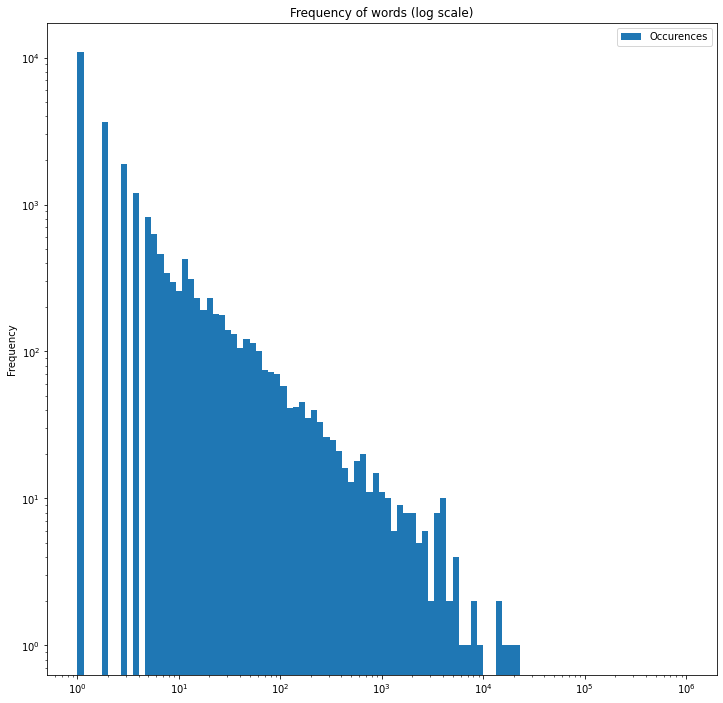

In [10]:
df_occurs.plot(kind='hist'\
              ,logx=True\
              ,logy=True\
              ,bins=np.logspace(0, 6, 100)\
              ,title='Frequency of words (log scale)'\
              ,figsize=(12,12))
plt.show()

### Part 2: Talkativity
**Q5**. For each of the recurrent characters, calculate their total number of words uttered across all episodes. Based on this, who seems to be the most talkative character?

In [11]:
recurrent_charac = list(df.index)
lines["# of words"] = lines["Line"].apply(lambda l: len(l.split(' ')))
nb_words_per_char = lines[lines["Character"].isin(recurrent_charac)]\
                   .groupby("Character")\
                   .sum(numeric_only=True)[["# of words"]]
nb_words_per_char

,# of words
Character,
Amy,37384
Arthur,1353
Bernadette,25810
Bert,1065
Beverley,1918
Emily,1472
Howard,64989
Kripke,1163
Leonard,95608


In [12]:
most_talk = nb_words_per_char.sort_values(by="# of words", ascending=False).reset_index().iloc[0]
print(f"The most talkative character is {most_talk[0]} with {most_talk[1]} words")

The most talkative character is Sheldon with 174919 words


## Task D: The Detective's Hat

Sheldon claims that given a dialogue line, he can, with an accuracy of above 70%, say whether it's by himself or by someone else. Leonard contests this claim, since he believes that this claimed accuracy is too high.

**Q6**. Divide the set of all dialogue lines into two subsets: the training set, consisting of all the seasons except the last two, and the test set, consisting of the last two seasons.

In [13]:
X_train = lines[lines["Season"] < max(lines["Season"].values)-1][["Character", "Line"]]
X_test = lines[lines["Season"] >= max(lines["Season"].values)-1][["Character", "Line"]]

**Q7**. Find the set of all words in the training set that are only uttered by Sheldon. Is it possible for Sheldon to identify himself only based on these? Use the test set to assess this possibility, and explain your method.

In [14]:
words_for_chars = pd.concat([pd.Series(row["Character"], row['Line'].split(' '))
                             for _, row in X_train.iterrows()])\
                           .reset_index()
words_for_chars.sample(5)

,index,0
304052,thy,Mr. Rostenkowski
462560,anyway,Bernadette
202112,readers,Sheldon
154406,guess,Leonard
447351,true,Stuart


In [15]:
words_for_chars.columns = ["Word", "Character"]
words_for_chars = words_for_chars.groupby("Word")["Character"].apply(set)
words_for_chars = pd.DataFrame(words_for_chars)
words_for_chars.sample(5)

,Character
Word,
melting,"{Bernadette, Leonard, Sheldon}"
graduated,{Sheldon}
download,"{Girl, Wil, Raj, Sheldon}"
soviet,{Third Floor Janitor}
reign,{Sheldon}


In [16]:
sheldon_words = list(words_for_chars[words_for_chars["Character"]\
                    .apply(lambda x: ("Sheldon" in x) and (len(x) == 1))]\
                    .index)
sheldon_words[345:350]

['antihistamine', 'antimony', 'antioxidants', 'antiproton', 'antisocial']

In [30]:
def is_sheldon(line):
    for word in line.split(" "):
        if word in(sheldon_words):
            return "Sheldon"
    return "Others"

X_test["Predict_Character"] = X_test["Line"].apply(is_sheldon)
X_test.sample(5)

,Character,Line,Predict_Character
44504,Howard,hi,Others
43826,Sheldon,oh wait i found something,Others
40542,Sheldon,wasnt mary magdalene a woman of ill repute,Others
47322,Sheldon,hmm you know perhaps instead of confronting th...,Sheldon
45039,Penny,the little choochoo for toddlers,Others


In [34]:
TP = len(X_test[(X_test["Character"] == "Sheldon") & (X_test["Predict_Character"] == "Sheldon")])
TN = len(X_test[(X_test["Character"] != "Sheldon") & (X_test["Predict_Character"] != "Sheldon")])
ALL = len(X_test)
print(f"Accuracy: {(TP+TN)/ALL}")

Accuracy: 0.783141342110075
